# sup10A

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


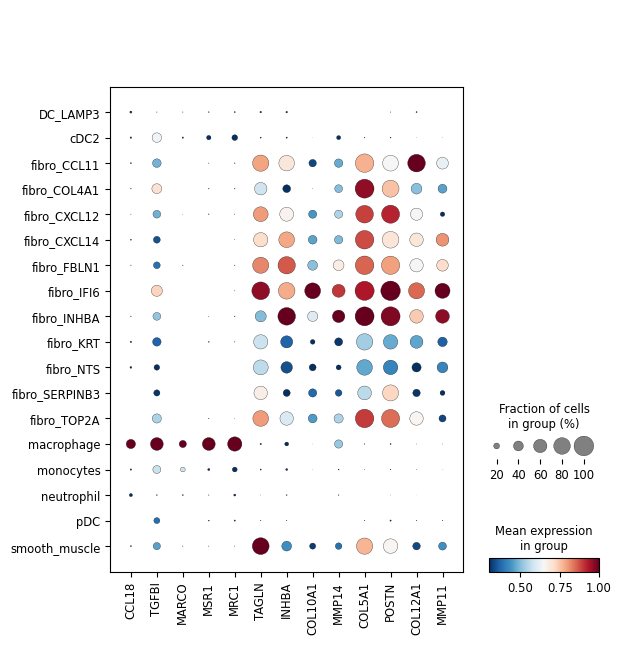

In [1]:
import scanpy as sc

rna = sc.read_h5ad('/data1/fengyu/methods/scRNA/LUAD_GSE148071/luad_forcellbin.h5ad')
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

sc.pl.dotplot(
    rna[rna.obs.anno.isin(['fibroblast', 'myeloid_cell'])],
    var_names=[
        'CCL18', 'TGFBI', 'MARCO', 'MSR1', 'MRC1',
        'TAGLN', 'INHBA', 'COL10A1', 'MMP14', 'COL5A1',
        'POSTN', 'COL12A1', 'MMP11'
    ],
    groupby='anno2',
    cmap='RdBu_r',
    standard_scale='var',
    vmin=0.3,
)

# sup10B


/tmp/ipykernel_2136695/3789628386.py:23: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  D06053D2_stroma.obs['Bcellexpansion'] = 'no'
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


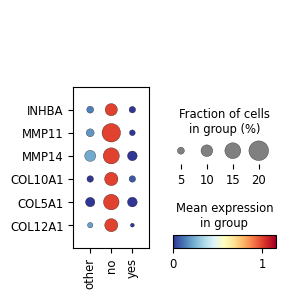

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


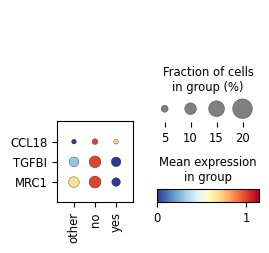

In [2]:
import scanpy as sc
import pandas as pd

# ---- 数据合并：添加B克隆扩增信息（每bin）
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
df = pd.read_csv('/data1/fengyu/methods/zy/Review/for_github/fig6--ok/bin50.Bcellclonesize.tsv', index_col=0)

original_index = adata.obs.index
tmp = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)
tmp.index = original_index
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

# ---- 拆出D06053D2的子集，和原始/test细胞AnnData及匹配信息 ----
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')
D06053D2 = adata[adata.obs.batch == 'D06053D2'].copy()
adata9.obs['loc'] = 'D06053D2_' + adata9.obs['bin50_x'].astype(str) + '_' + adata9.obs['bin50_y'].astype(str)

# ---- 标注bin是否扩增 ----
D06053D2_stroma = D06053D2[D06053D2.obs['annotation'].isin(['Stroma', 'LA-PCA', 'LA-TLS', 'LA-myloid-aggregate'])]
D06053D2_stroma.obs['Bcellexpansion'] = 'no'
D06053D2_stroma.obs.loc[D06053D2_stroma.obs['B_clone_expansion_n_cells'] >= 2, 'Bcellexpansion'] = 'yes'

# ---- 把扩增标签合并进D06053D2测试AnnData ----
adata9.obs = adata9.obs.merge(
    D06053D2_stroma[D06053D2_stroma.obs['loc'].isin(adata9.obs['loc'])].obs[['loc', 'Bcellexpansion']],
    on='loc', how='outer'
)
adata9.obs['Bcellexpansion'] = adata9.obs['Bcellexpansion'].astype(str)
adata9.obs.loc[adata9.obs['Bcellexpansion'] == 'nan', 'Bcellexpansion'] = 'other'

adata9.obs_names = adata9.obs_names.astype(str)
adata9.var_names = adata9.var_names.astype(str)

# ---- fibroblast dotplot ----
fibroblast = adata9[adata9.obs['anno'] == 'fibroblast']
sc.pl.dotplot(
    fibroblast,
    ['INHBA', 'MMP11', 'MMP14', 'COL10A1', 'COL5A1', 'COL12A1'],
    groupby='Bcellexpansion',
    use_raw=False,
    swap_axes=True,
    standard_scale='var',
    cmap='RdYlBu_r',
    vmax=1.15,
    dot_max=0.2,
    categories_order=['other', 'no', 'yes'],
    save='Sup11B_left.pdf'
)

# ---- macrophage dotplot ----
adata9.obs.index = adata9.obs.index.astype(str)
sc.pl.dotplot(
    adata9[adata9.obs['anno2'] == 'macrophage'],
    ['CCL18','TGFBI','MRC1'],
    groupby='Bcellexpansion',
    standard_scale='var',
    cmap='RdYlBu_r',
    vmax=1.15,
    swap_axes=True,
    categories_order=['other', 'no', 'yes'],
    dot_max=0.2,

)

# sup10C

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


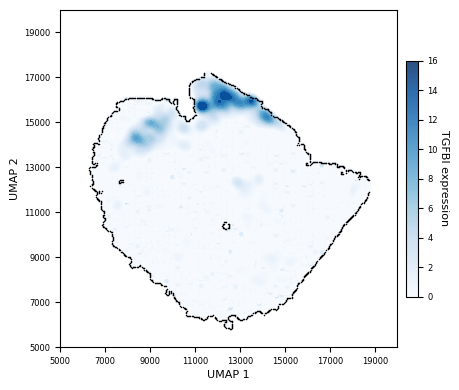

In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 数据准备 ---
adata11 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')
tissue_outline = pd.DataFrame(adata11.uns['tissue_outline'], columns=['x', 'y'])

umap_coords = pd.DataFrame(
    adata11.obsm['X_umap'][:, :2],
    index=adata11.obs_names,
    columns=['UMAP_1', 'UMAP_2']
)
gene = 'TGFBI'
# 适应稠密/稀疏的基因表达取值
if hasattr(adata11.X, 'toarray'):
    gene_expr = adata11[:, gene].X.toarray().flatten()
elif hasattr(adata11.X, 'A'):
    gene_expr = adata11[:, gene].X.A.flatten()
else:
    gene_expr = adata11[:, gene].X

plot_df = pd.DataFrame({
    'UMAP_1': umap_coords['UMAP_1'],
    'UMAP_2': umap_coords['UMAP_2'],
    gene: gene_expr
})

# --- 2. 绘图 ---
fig, ax = plt.subplots(figsize=(5, 4))

# 2.1: UMAP scatter, colored by gene
scatter = ax.scatter(
    plot_df['UMAP_1'],
    plot_df['UMAP_2'],
    c=plot_df[gene],
    cmap='Blues',
    s=5,
    alpha=0.85
)

# 2.2: Weighted density (only cells with expression > 0)
sns.kdeplot(
    data=plot_df[plot_df[gene] > 0],
    x='UMAP_1',
    y='UMAP_2',
    weights=gene,
    fill=True,
    cmap='Blues',
    alpha=1,
    levels=30,
    bw_adjust=0.3,
    thresh=0.5,
    linewidths=0.5,
)

# 2.3: Tissue outline overlay (optional, in "x", "y" sample scale)
sns.scatterplot(
    data=tissue_outline,
    x='x', y='y',
    color='black',
    s=1,
    edgecolor=None,
)

# --- 2.4: 坐标轴、色条等美化 ---
ax.set_xlabel('UMAP 1', fontsize=8, labelpad=3)
ax.set_ylabel('UMAP 2', fontsize=8, labelpad=3)
ax.set_xlim(5000, 20000)
ax.set_ylim(5000, 20000)
ax.set_xticks(range(5000, 20001, 2000))
ax.set_yticks(range(5000, 20001, 2000))
ax.tick_params(axis='both', which='major', labelsize=6)
plt.grid(False)
cbar = fig.colorbar(scatter, ax=ax, pad=0.02, fraction=0.03, shrink=0.7)
cbar.set_label(f'{gene} expression', rotation=270, labelpad=8, fontsize=8)
cbar.ax.tick_params(labelsize=6)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# sup10DEFG

表达 CD34 的细胞数：127
Begin robust gene identification
After filtration, 26917/32351 genes are kept.     Among 26917 genes, 20612 genes are robust.
End of robust gene identification.
Begin size normalization: pearson and HVGs selection pearson
Time to analyze data in cpu: 3.167935609817505 seconds.
End of size normalization: pearson and HVGs selection pearson
🖥️ Using Scanpy CPU to calculate neighbors...
🔍 [2026-02-03 17:04:54] Running UMAP in 'cpu' mode...
🖥️ Using Scanpy CPU UMAP...
✅ UMAP completed successfully.


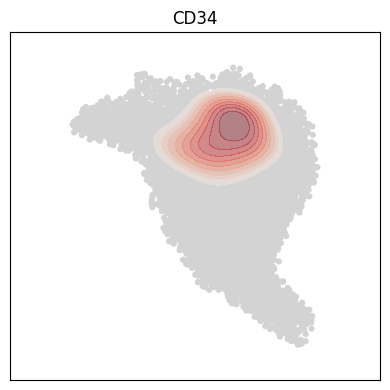

In [3]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import omicverse as ov

# --- 1. 读入原始 fibroblast 子集（已是 AnnData 子集）---
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')
fibroblast = adata9[adata9.obs['anno'] == 'fibroblast'].copy()

# --- 2. 检查并输出 CD34阳性细胞总数 ---
if 'CD34' not in fibroblast.var_names:
    raise ValueError('CD34 不在 var_names 中，请检查基因名')
cd34_expr = fibroblast[:, 'CD34'].X
if hasattr(cd34_expr, "toarray"):
    cd34_expr_dense = cd34_expr.toarray().flatten()
else:
    cd34_expr_dense = np.asarray(cd34_expr).flatten()
n_positive = int(np.sum(cd34_expr_dense > 0))
print(f'表达 CD34 的细胞数：{n_positive}')

# --- 3. omicverse 预处理和降维（如已做可跳过）---
fibroblast = ov.pp.preprocess(fibroblast, mode='pearson|pearson', n_HVGs=3000)
fibroblast.raw = fibroblast  # 让 .raw 用于后续 var筛选、图绘原始表达
fibroblast = fibroblast[:, fibroblast.var.highly_variable_features]
ov.pp.scale(fibroblast)
ov.pp.pca(fibroblast, layer='scaled', n_pcs=50)
ov.pp.neighbors(fibroblast, n_neighbors=15, n_pcs=50, use_rep='scaled|original|X_pca')
ov.pp.umap(fibroblast)

# --- 4. UMAP坐标 & 原始表达量 ---
umap_coords = fibroblast.obsm["X_umap"]
try:
    cd34_used = fibroblast.raw[:, "CD34"].X
except Exception:
    cd34_used = fibroblast[:, "CD34"].X
if hasattr(cd34_used, "toarray"):
    cd34_val = cd34_used.toarray().flatten()
else:
    cd34_val = np.asarray(cd34_used).flatten()

# --- 5. 绘图 (灰色背景点 + CD34加权红色等高线KDE) ---
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(
    umap_coords[:, 0],
    umap_coords[:, 1],
    s=20,
    color="lightgrey",
    edgecolor="none"
)
weights_safe = np.clip(cd34_val, 0, None)
sns.kdeplot(
    x=umap_coords[:, 0],
    y=umap_coords[:, 1],
    weights=weights_safe,
    fill=True,
    thresh=0.5,
    cmap="Reds",
    alpha=0.4,
    ax=ax
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("CD34")
plt.grid(False)
plt.axis('equal')
plt.tight_layout()
plt.show()

Loading AnnData objects...
Merging clone data...
Subsetting AnnData for D06053D2 sample...
Annotating regions for B cell clonal expansion...
Selecting and preprocessing fibroblast subset...
Begin robust gene identification
After filtration, 26917/32351 genes are kept.     Among 26917 genes, 20612 genes are robust.
End of robust gene identification.
Begin size normalization: pearson and HVGs selection pearson
Time to analyze data in cpu: 2.6131887435913086 seconds.
End of size normalization: pearson and HVGs selection pearson
🖥️ Using Scanpy CPU to calculate neighbors...
🔍 [2026-02-03 17:46:14] Running UMAP in 'cpu' mode...
🖥️ Using Scanpy CPU UMAP...
✅ UMAP completed successfully.
Performing trajectory inference...
Plotting UMAP colored by DPT pseudotime...


<Figure size 640x480 with 0 Axes>

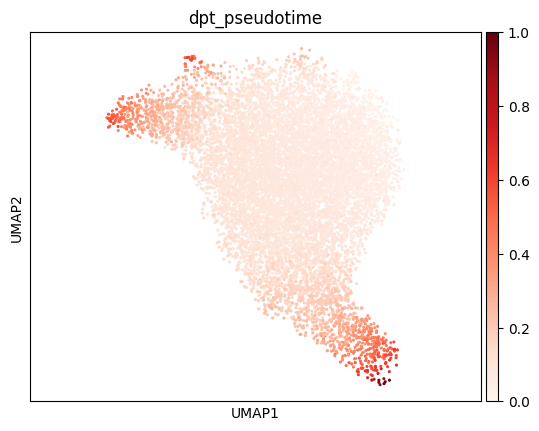

Plotting KDE overlays for B cell expansion/no expansion...


<Figure size 1000x800 with 0 Axes>

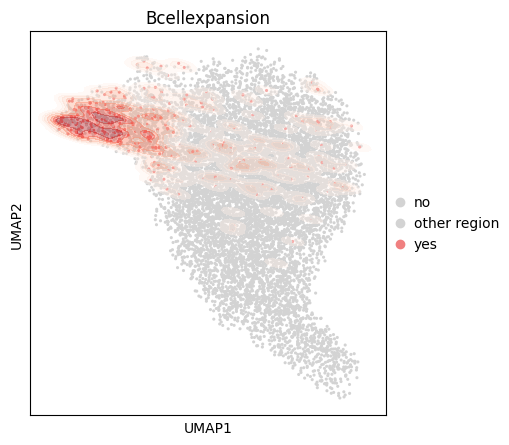

<Figure size 1000x800 with 0 Axes>

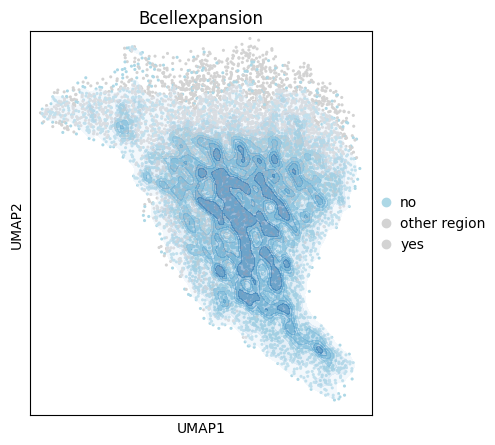

Plotting categorical UMAP with KDE overlay for expanded regions...


<Figure size 1000x800 with 0 Axes>

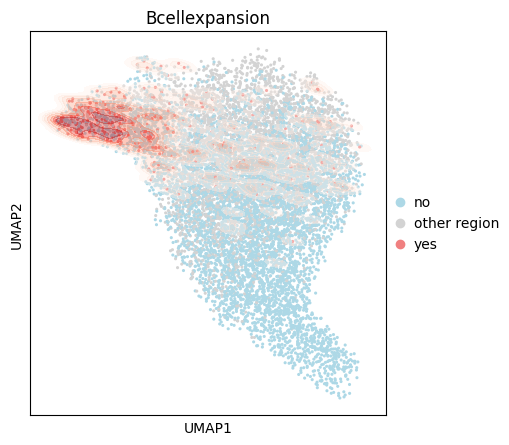

Computing and plotting the PAGA graph for fibroblast trajectory...
running PAGA using priors: ['dpt_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


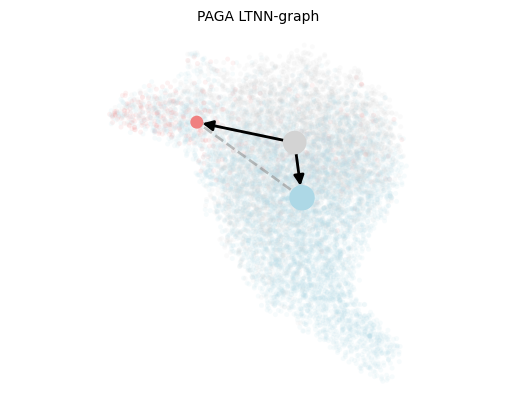

Overlaying spatial tissue outline with dpt_pseudotime coloring...


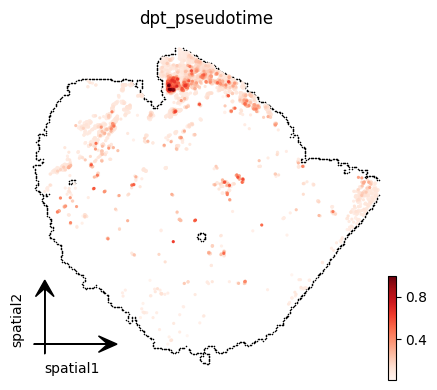

In [8]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import omicverse as ov
# -------------------------------------------
# 1. Load Data
# -------------------------------------------
print("Loading AnnData objects...")
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
clone_df = pd.read_csv('/data1/fengyu/methods/zy/Review/for_github/fig6--ok/bin50.Bcellclonesize.tsv', index_col=0)

# -------------------------------------------
# 2. Merge clone size data into AnnData
# -------------------------------------------
print("Merging clone data...")
# Save the original index
original_index = adata.obs.index.copy()
# Merge on 'loc', filling missing clone size as 0
tmp = adata.obs.merge(clone_df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)
tmp.index = original_index
# Update obs with new columns
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

# -------------------------------------------
# 3. Subset for single sample and map clone data
# -------------------------------------------
print("Subsetting AnnData for D06053D2 sample...")
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')
D06053D2 = adata[adata.obs.batch=='D06053D2'].copy()
adata9.obs['loc'] = 'D06053D2_' + adata9.obs['bin50_x'].astype(str) + '_' + adata9.obs['bin50_y'].astype(str)
adata9.obs = adata9.obs.merge(
    D06053D2.obs[['loc', 'B_clone_expansion_n_cells']],
    on='loc',
    how='left',
)

# -------------------------------------------
# 4. Annotate B cell expansion status
# -------------------------------------------
print("Annotating regions for B cell clonal expansion...")
stroma_like = [
    'Stroma', 'LA-PCA', 'LA-TLS', 'LA-myloid-aggregate'
]
# Start with default label for all regions
adata9.obs['Bcellexpansion'] = 'other region'
condition_no = (
    (adata9.obs['B_clone_expansion_n_cells'] < 2) &
    (adata9.obs['bin50 structural annotation'].isin(stroma_like))
)
condition_yes = (
    (adata9.obs['B_clone_expansion_n_cells'] >= 2) &
    (adata9.obs['bin50 structural annotation'].isin(stroma_like))
)
adata9.obs.loc[condition_no, 'Bcellexpansion'] = 'no'
adata9.obs.loc[condition_yes, 'Bcellexpansion'] = 'yes'

# Ensure AnnData indices are strings
adata9.obs_names = adata9.obs_names.astype(str)
adata9.var_names = adata9.var_names.astype(str)

# -------------------------------------------
# 5. Preprocess fibroblast cells for analysis
# -------------------------------------------
print("Selecting and preprocessing fibroblast subset...")
fibroblast = adata9[adata9.obs['anno'] == 'fibroblast']
fibroblast = ov.pp.preprocess(fibroblast, mode='pearson|pearson', n_HVGs=3000)
fibroblast.raw = fibroblast
fibroblast = fibroblast[:, fibroblast.var.highly_variable_features]
ov.pp.scale(fibroblast)
ov.pp.pca(fibroblast, layer='scaled', n_pcs=50)
ov.pp.neighbors(fibroblast, n_neighbors=15, n_pcs=50, use_rep='scaled|original|X_pca')
ov.pp.umap(fibroblast)

# -------------------------------------------
# 6. Trajectory inference using Omivor (ov)
# -------------------------------------------
print("Performing trajectory inference...")
Traj = ov.single.TrajInfer(
    fibroblast,
    basis='X_umap',
    groupby='Bcellexpansion',
    use_rep='scaled|original|X_pca',
    n_comps=50,
)
Traj.set_origin_cells('other region')
Traj.inference(method='diffusion_map')

# -------------------------------------------
# 7. UMAP colored by pseudotime
# -------------------------------------------
print("Plotting UMAP colored by DPT pseudotime...")
plt.figure()
sc.pl.umap(
    fibroblast,
    color=['dpt_pseudotime'],
    cmap='Reds',
    s=20,
    show=False
)
plt.axis('equal')
plt.show()

# -------------------------------------------
# 8. UMAP with KDE overlay for regions with/without Bcell expansion
# -------------------------------------------
print("Plotting KDE overlays for B cell expansion/no expansion...")

def plot_umap_kde(
    adata,
    mask_label,
    color,
    kde_cmap,
    kde_label,
    filename
):
    # Custom color palette: highlight only selected label
    custom_palette = {
        "no": "lightgrey",
        "yes": "lightgrey",
        "other region": "lightgrey"
    }
    custom_palette[mask_label] = color
    plt.figure(figsize=(10, 8))
    sc.pl.umap(
        adata,
        color=["Bcellexpansion"],
        s=20,
        palette=custom_palette,
        show=False
    )
    mask = adata.obs["Bcellexpansion"] == mask_label
    x = adata.obsm["X_umap"][mask, 0]
    y = adata.obsm["X_umap"][mask, 1]
    ax = plt.gca()
    sns.kdeplot(
        x=x,
        y=y,
        ax=ax,
        cmap=kde_cmap,
        levels=8,
        bw_adjust=0.3,
        alpha=0.4,
        fill=True
    )
    ax.set_aspect('equal')
    ax.set_position([0.1, 0.1, 0.8, 0.8])
    plt.show()


plot_umap_kde(
    fibroblast, "yes", "lightcoral", "Reds", "B cell clonal expansion", "Sup11F2.pdf"
)
plot_umap_kde(
    fibroblast, "no", "lightblue", "Blues", "No clonal expansion", "Sup11_F1.pdf"
)

# -------------------------------------------
# 9. UMAP with categorical coloring and KDE overlay ("yes" group)
# -------------------------------------------
print("Plotting categorical UMAP with KDE overlay for expanded regions...")
custom_palette = {
    "no": "lightblue",
    "other region": "lightgrey",
    "yes": "lightcoral"
}
plt.figure(figsize=(10, 8))
sc.pl.umap(
    fibroblast,
    color=["Bcellexpansion"],
    s=20,
    palette=custom_palette,
    show=False
)
# Overlay KDE for "yes" regions
yes_mask = fibroblast.obs["Bcellexpansion"] == "yes"
x = fibroblast.obsm["X_umap"][yes_mask, 0]
y = fibroblast.obsm["X_umap"][yes_mask, 1]
ax = plt.gca()
sns.kdeplot(
    x=x,
    y=y,
    ax=ax,
    cmap="Reds",
    levels=8,
    bw_adjust=0.3,
    alpha=0.4,
    fill=True
)
ax.set_aspect('equal')
ax.set_position([0.1, 0.1, 0.8, 0.8])
plt.show()

# -------------------------------------------
# 10. PAGA graph inference and plotting
# -------------------------------------------
print("Computing and plotting the PAGA graph for fibroblast trajectory...")
ov.utils.cal_paga(fibroblast, use_time_prior='dpt_pseudotime', vkey='paga', groups='Bcellexpansion')
ov.utils.plot_paga(
    fibroblast,
    basis='umap',
    size=50,
    alpha=0.1,
    title='PAGA LTNN-graph',
    min_edge_width=2,
    node_size_scale=1.5,
    show=False,
    legend_loc=False
)
plt.axis('equal')
plt.show()

# -------------------------------------------
# 11. Spatial embedding with tissue outline
# -------------------------------------------
print("Overlaying spatial tissue outline with dpt_pseudotime coloring...")
tissue_outline = pd.DataFrame(
    adata9.uns['tissue_outline'],
    columns=['x', 'y']
)
fig, ax = plt.subplots(figsize=(4.5, 4))
# Draw spatial outline
sns.scatterplot(
    data=tissue_outline, x='x', y='y',
    color='black', s=1, edgecolor=None, ax=ax
)
# Plot spatial embedding for "no clonal expansion" fibroblast
ov.utils.embedding(
    fibroblast[fibroblast.obs['Bcellexpansion'] == 'no'],
    basis='spatial',
    color=['dpt_pseudotime'],
    frameon='small',
    cmap='Reds',
    show=False,
    ax=ax
)
plt.tight_layout()
ax.set_aspect('equal')
plt.show()

# sup10H

/tmp/ipykernel_2598316/473919919.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  D06053D2_stroma.obs['Bcellexpansion'] = 'no'


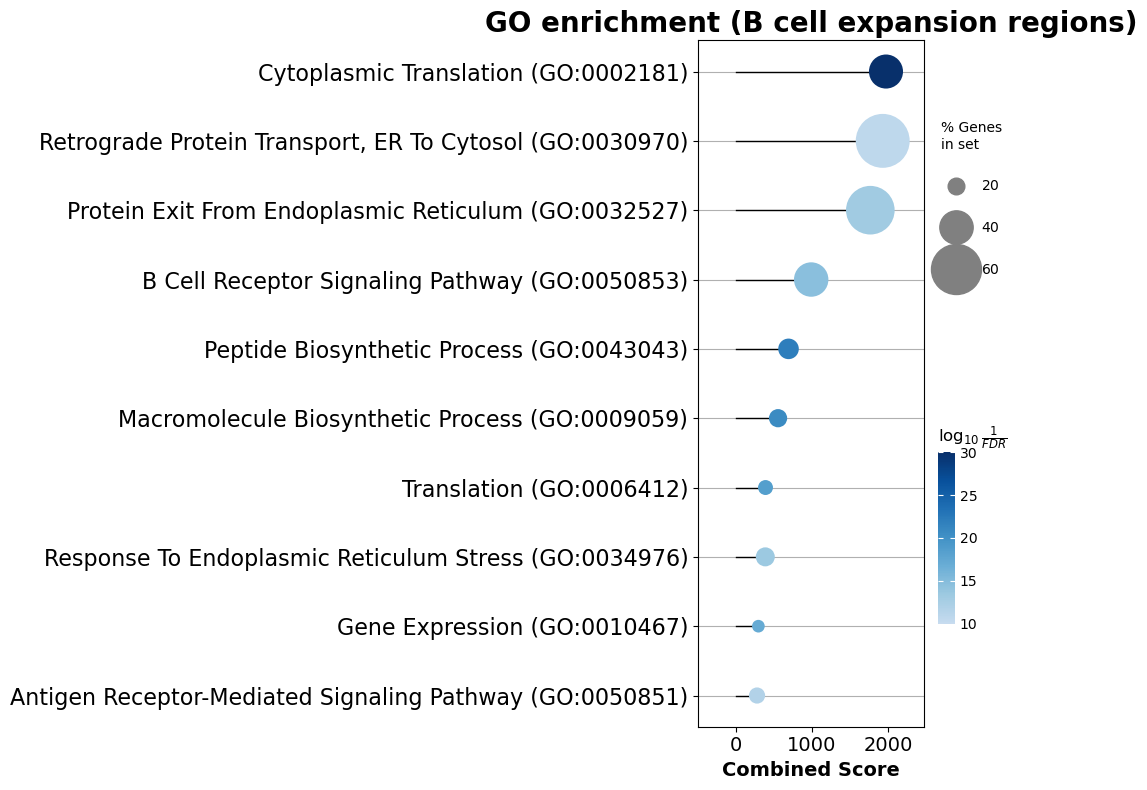

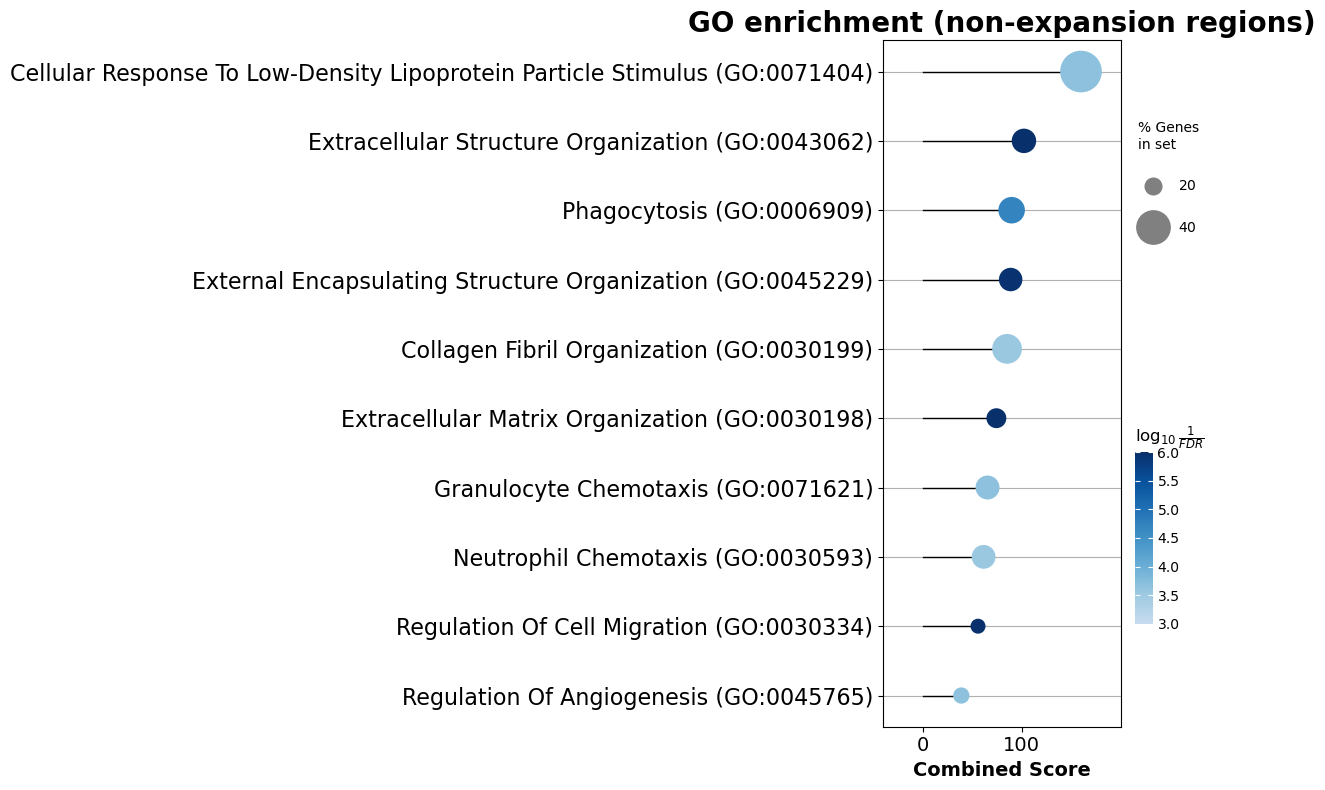

GO enrichment analysis and plotting complete.


In [2]:
import scanpy as sc
import gseapy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.colors as mcolors
import seaborn as sns
import os

# -------------------------------
# 1. Load single-cell dataset and merged clone info
# -------------------------------
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
external_df = pd.read_csv('/data1/fengyu/methods/zy/Review/for_github/fig6--ok/bin50.Bcellclonesize.tsv', index_col=0)

# Merge clone size info to AnnData.obs
original_index = adata.obs.index
tmp = adata.obs.merge(external_df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)
tmp.index = original_index
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

# -------------------------------
# 2. Subset to one sample and stroma-like regions
# -------------------------------
D06053D2 = adata[adata.obs.batch == 'D06053D2'].copy()
stroma_types = ['Stroma', 'LA-PCA', 'LA-TLS', 'LA-myloid-aggregate']
D06053D2_stroma = D06053D2[D06053D2.obs['annotation'].isin(stroma_types)]

# Annotate B cell clonal expansion
D06053D2_stroma.obs['Bcellexpansion'] = 'no'
D06053D2_stroma.obs.loc[
    D06053D2_stroma.obs['B_clone_expansion_n_cells'] >= 2, 'Bcellexpansion'
] = 'yes'

# -------------------------------
# 3. Normalize and find DEGs between expanded vs. not-expanded
# -------------------------------
sc.pp.normalize_total(D06053D2_stroma, target_sum=1e4)
sc.pp.log1p(D06053D2_stroma)
sc.tl.rank_genes_groups(
    D06053D2_stroma, groupby='Bcellexpansion', method='t-test', use_raw=False, key_added='rank_yes_vs_no'
)

# Make sure B_clone_expansion_n_cells column is string type
D06053D2_stroma.obs['B_clone_expansion_n_cells'] = D06053D2_stroma.obs['B_clone_expansion_n_cells'].astype(str)

def get_deg_genes(adata, group, key, min_logfc=0, max_padj=0.05):
    """Return list of significant up-regulated DEGs for group (positive logFC, padj < max_padj)."""
    result = sc.get.rank_genes_groups_df(adata, group=group, key=key)
    degs = result[
        (result['logfoldchanges'] > min_logfc) & (result['pvals_adj'] < max_padj)
    ]
    return degs['names'].tolist(), degs

# -------------------------------
# 4. Functional Enrichment (GO terms) - for "yes" (expansion) regions
# -------------------------------
deg_genes_yes, deg_yes_df = get_deg_genes(D06053D2_stroma, group='yes', key='rank_yes_vs_no')

go_results_yes = gp.enrichr(
    gene_list=deg_genes_yes,
    gene_sets=['GO_Biological_Process_2023'],
    organism='human',
    outdir=None,
    cutoff=0.1
)

# -------------------------------
# 5. Plot GO enrichment - Top10 terms (Expanding regions, left panel)
# -------------------------------
def adjust_legend_marker_size(legend, scale_factor):
    """Adjust legend marker size (for scatter plot legends)."""
    if legend:
        for handle in legend.legend_handles:
            if isinstance(handle, matplotlib.collections.PathCollection):
                handle.set_sizes([s * scale_factor for s in handle.get_sizes()])
            elif isinstance(handle, plt.Line2D):
                handle.set_markersize(handle.get_markersize() * scale_factor)

def plot_custom_dotplot(go_results,title='GO enrichment', fig_size=(10, 8), cmap_range=(0.25, 1)):
    """Draw dotplot with customized markers and horizontal lines."""
    # Customize colormap: cut low intensity
    blues = plt.get_cmap('Blues')
    new_colors = blues(np.linspace(cmap_range[0], cmap_range[1], 256))
    new_cmap = mcolors.LinearSegmentedColormap.from_list('Blues_trimmed', new_colors)

    # Create temp plot to get scatter position
    temp_ax = gp.dotplot(go_results.res2d, title='', top_terms=10, cutoff=2, cmap=new_cmap, return_ax=True)
    points_data = temp_ax.collections[0].get_offsets()
    plt.close()

    # Main plot: add horizontal lines first
    fig, ax = plt.subplots(figsize=fig_size)
    for x, y in points_data:
        ax.plot([0, x], [y, y], color='black', linestyle='-', linewidth=1)

    # Overlay dotplot
    ax = gp.dotplot(go_results.res2d, title=title, top_terms=10, cutoff=2, cmap=new_cmap, ax=ax, size=10)
    legend = ax.get_legend()
    adjust_legend_marker_size(legend, scale_factor=1)
    plt.tight_layout()
    fig = ax.figure
    fig.canvas.draw()
    plt.show()

# Plot left panel: "yes" group
plot_custom_dotplot(go_results_yes, title='GO enrichment (B cell expansion regions)', fig_size=(10,8))

# -------------------------------
# 6. Repeat: Enrichment for "no" (non-expansion) stroma regions
# -------------------------------
deg_genes_no, deg_no_df = get_deg_genes(D06053D2_stroma, group='no', key='rank_yes_vs_no')
go_results_no = gp.enrichr(
    gene_list=deg_genes_no,
    gene_sets=['GO_Biological_Process_2023'],
    organism='human',
    outdir=None,
    cutoff=0.1
)
# Right panel: "no" group
plot_custom_dotplot(go_results_no, title='GO enrichment (non-expansion regions)', fig_size=(12,8))

print("GO enrichment analysis and plotting complete.")

# sup10I

Loading single-cell AnnData...


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Subtype-to-color mapping:
CD8T_Tex_CXCL13	#1f77b4
CD8T_Tem_GZMK+GZMH+	#aec7e8
CD8T_Tem_GZMK+NR4A1+	#ff7f0e
CD8T_Trm_ZNF683	#ffbb78
CD8T_Tm_IL7R	#2ca02c
CD8T_terminal_Tex_LAYN	#98df8a
CD8T_NK-like_FGFBP2	#d62728
CD4T_Th1-like_CXCL13	#ff9896
CD8T_prf_MKI67	#9467bd
CD4T_Treg_FOXP3	#c5b0d5
CD4T_Tem_GZMA	#8c564b
CD4T_Treg_CCR8	#c49c94
CD8T_ISG15	#e377c2
CD4T_Tfh_CXCL13	#f7b6d2
CD4T_Tm_ANXA1	#7f7f7f
T_gdT_TRDV1	#c7c7c7
CD8T_MAIT_KLRB1	#bcbd22
CD4T_Tn_CCR7	#dbdb8d
CD4T_Tm_XCL1	#17becf
NK_CD16hi_FGFBP2	#9edae5
T_gdT_TRDV2	#9edae5
NK_CD16low_GZMK	#9edae5
CD4T_Treg_MKI67	#9edae5
ILC3_KIT	#9edae5


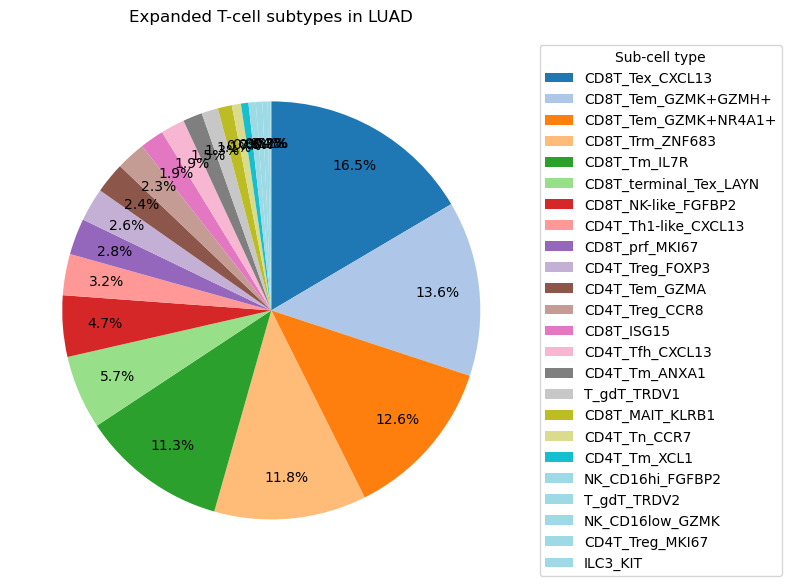

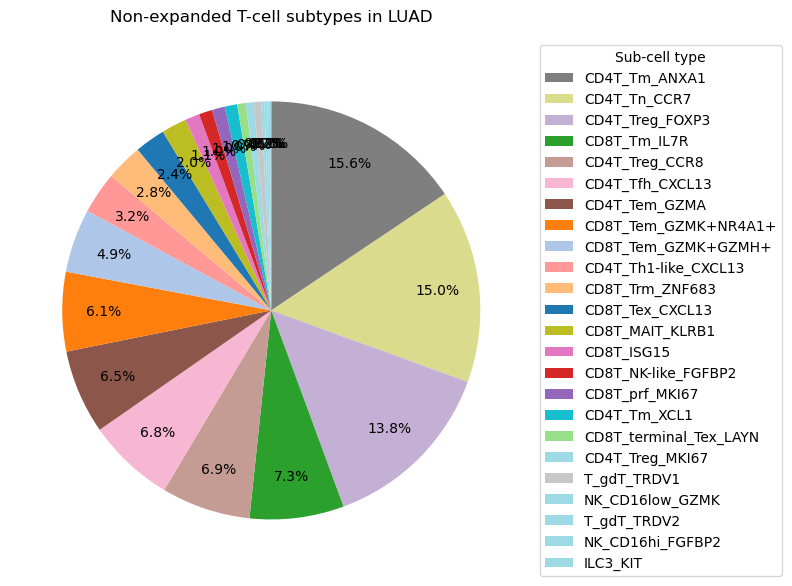

Pie charts and color mapping exported.


In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ---------------------------
# 1. Load data and subset for LUAD T/NK cells
# ---------------------------
print("Loading single-cell AnnData...")
rna = sc.read_h5ad('/data1/zhangyang/Method/Review/Reviewer1/point.8/GSE243013_NSCLC_immune_scRNA_with_TCR.h5ad')
tmp = rna[rna.obs['cancer_type'] == 'LUAD']
Tcell = tmp[tmp.obs['major_cell_type'] == 'T/NK cell']

# ---------------------------
# 2. Pie chart for expanded subtypes
# ---------------------------
exp_counts = Tcell[Tcell.obs['expansion'] == 'expanded'].obs['sub_cell_type_x'].value_counts()
non_exp_counts = Tcell[Tcell.obs['expansion'] == 'non-expanded'].obs['sub_cell_type_x'].value_counts()

# ---------------------------
# 3. Assign colors (consistent for all pie charts)
# ---------------------------
exp_types = exp_counts.index.tolist()
non_exp_types = non_exp_counts.index.tolist()
all_types = list(dict.fromkeys(exp_types + non_exp_types))  # unique, preserve order

# Use tab20 for up to 20 subtypes. Adjust if you have more types.
cmap = plt.get_cmap('tab20')
colors_all = [cmap(i) for i in range(len(all_types))]
hex_colors = [mcolors.to_hex(c) for c in colors_all]
type2color = dict(zip(all_types, hex_colors))

# Optionally, print and save color mapping
print("Subtype-to-color mapping:")
for t, c in type2color.items():
    print(f"{t}\t{c}")
with open('celltype_color_map.txt', 'w') as f:
    for t, c in type2color.items():
        f.write(f"{t}\t{c}\n")

# ---------------------------
# 4. Pie chart: Expanded T cells
# ---------------------------
exp_colors = [type2color[t] for t in exp_types]
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    exp_counts,
    labels=None,  # legend instead of inline labels
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    pctdistance=0.8,
    colors=exp_colors
)
ax.legend(
    wedges,
    exp_types,
    title='Sub-cell type',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)
ax.set_title('Expanded T-cell subtypes in LUAD', pad=20)
plt.tight_layout()
plt.savefig('LUAD_expanded_Tcell_pie.pdf', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 5. Pie chart: Non-expanded T cells
# ---------------------------
non_exp_colors = [type2color[t] for t in non_exp_types]
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    non_exp_counts,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    pctdistance=0.8,
    colors=non_exp_colors
)
ax.legend(
    wedges,
    non_exp_types,
    title='Sub-cell type',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)
ax.set_title('Non-expanded T-cell subtypes in LUAD', pad=20)
plt.tight_layout()
plt.show()

print("Pie charts and color mapping exported.")